In [5]:
%ls ../input
%ls ../input/synimg/synimg/train/Beijing | head -5


synimg/
train-Beijing-1050000.jpg
train-Beijing-1050001.jpg
train-Beijing-1050002.jpg
train-Beijing-1050003.jpg
train-Beijing-1050004.jpg


In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras import backend as K
import skimage.io as io
import os
import matplotlib.pylab as plt
import numpy as np
import pandas as pd


Using TensorFlow backend.


In [7]:
WIDTH = 64
HEIGHT = 32
ROOT_PATH = '../input/synimg/'

# Objectives of this setting up / exploratory script:
* Setup all environments (libraries/ dependencies. Folder structure to be compatible with Kaggle kernel)
* Doing basic input/output. Output that is compatible with submission format
* Some basic utility functions:
    * show image
    * image to binary array data
    * binary data back to image data
    * some dumb features transformation
* Dummy model
* Dummy model but makes use of some image data
* Dummy CNN model but include some troubleshooting and/or training/testing 

# Step 1: Doing input/output

In [8]:
def read_data_from_file(filename, nrows=None):
    '''
        File is in the format of data.csv or data_nostyle.csv, 
        containing location of each image and IDs and/or la
        filename example: 'synimg/test/data_nostyle.csv'
    '''
    data = pd.read_csv(ROOT_PATH + filename, nrows=nrows)
    all_images = []
    for idx, row in data.iterrows():
        img = io.imread(ROOT_PATH + row['filepath'])
        all_images.append(img)
#     all_images.shape
    return data, all_images


def read_labels():
    style_labels = pd.read_csv(ROOT_PATH + 'synimg/styles.txt', names=['style'])
    label_to_labelId, labelId_to_label = {}, {}
    for idx, style in enumerate(style_labels['style']):
        label_to_labelId[style] = idx
        labelId_to_label[idx] = style
    return style_labels, label_to_labelId, labelId_to_label
    

In [11]:
style_labels, label_to_labelId, labelId_to_label = read_labels()

train_data, train_images = read_data_from_file('synimg/train/data.csv', nrows=100)
print("Shape & Binary format of each image", train_images[0].shape, "\n", train_images[0][:1])
train_data['labelId'] = train_data['style_name'].map(label_to_labelId)
train_data.tail(10)


Shape & Binary format of each image (32, 64, 3) 
 [[[  0   4   2]
  [  0   2  21]
  [  0   4  18]
  [  0  10   0]
  [  0  16   0]
  [  0  13   0]
  [  0   9  13]
  [  0  13  41]
  [  0  13  46]
  [  0   9  75]
  [  1   0 130]
  [  2   0 167]
  [  4   0 157]
  [  6   0 136]
  [  5   0 145]
  [  5   0 169]
  [  2   6   9]
  [  0   4   0]
  [  0   1   7]
  [  0   0  69]
  [  0   0 118]
  [  0   0 104]
  [  0   2  48]
  [  0   1  28]
  [  0   0  72]
  [  0   0 100]
  [  0   0  76]
  [  0   0  27]
  [  0   2   0]
  [  0   0   2]
  [  2   0  18]
  [  7   1  27]
  [  4   0   7]
  [  4   0   4]
  [ 16  11   8]
  [255 255 244]
  [254 253 233]
  [252 252 226]
  [255 255 230]
  [255 255 232]
  [254 255 232]
  [254 255 234]
  [254 255 235]
  [254 255 235]
  [254 255 232]
  [254 255 228]
  [253 255 225]
  [253 255 223]
  [254 255 239]
  [254 255 239]
  [254 255 239]
  [254 255 239]
  [254 255 239]
  [254 255 239]
  [254 255 239]
  [254 255 239]
  [254 255 239]
  [254 255 239]
  [254 255 239]
  [254

,id,style_name,file,filepath,labelId
90,1000090,Luanda,train-Luanda-1000090.jpg,synimg/train/Luanda/train-Luanda-1000090.jpg,0
91,1000091,Luanda,train-Luanda-1000091.jpg,synimg/train/Luanda/train-Luanda-1000091.jpg,0
92,1000092,Luanda,train-Luanda-1000092.jpg,synimg/train/Luanda/train-Luanda-1000092.jpg,0
93,1000093,Luanda,train-Luanda-1000093.jpg,synimg/train/Luanda/train-Luanda-1000093.jpg,0
94,1000094,Luanda,train-Luanda-1000094.jpg,synimg/train/Luanda/train-Luanda-1000094.jpg,0
95,1000095,Luanda,train-Luanda-1000095.jpg,synimg/train/Luanda/train-Luanda-1000095.jpg,0
96,1000096,Luanda,train-Luanda-1000096.jpg,synimg/train/Luanda/train-Luanda-1000096.jpg,0
97,1000097,Luanda,train-Luanda-1000097.jpg,synimg/train/Luanda/train-Luanda-1000097.jpg,0
98,1000098,Luanda,train-Luanda-1000098.jpg,synimg/train/Luanda/train-Luanda-1000098.jpg,0
99,1000099,Luanda,train-Luanda-1000099.jpg,synimg/train/Luanda/train-Luanda-1000099.jpg,0


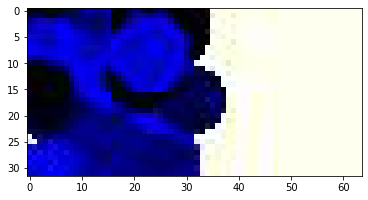

In [12]:
plt.imshow(train_images[0])

# Step 2: Model

In [7]:
import random
from random import randint

def dummy_model(images):
    ''' Dummy model for now '''
    preds = np.zeros(len(images))
    for idx, img in enumerate(images):
        preds[idx] = random.randint(0, len(label_to_labelId) - 1)
    return preds
    

## Explore features

A few observations:
    * Shapes (circles) are mostly standard in sizes, just variation in terms of colours and positions (scattering patterns)
    * Even with colours it's not map to standard colours, but looks like it has continuous ranges (e.g. white and near-white). Perhaps even got an alpha channel blended in
    * Simple ideas is to standaridise it, to make colours a discriminative features. Let's just exploit this as a unique single feature

In [16]:
import scipy.spatial as sp
import numpy as np

main_colors = [
    (0,0,0), (255,255,255), (255,0,0), (0,255,0),
    (0,0,255), (255,255,0), (0,255,255), (255,0,255)
]

def convert_nearest_std_colors(image):
    ''' convert each pixel image to its nearest color, sort of Gaussian filtering,
    but do it explicitly '''
    # print("Before conversion")
    # plt.imshow(image)


    h, w, bpp = np.shape(image)
    hist = np.zeros(len(main_colors))

    for py in range(0,h):
        for px in range(0,w):
            input_color = (image[py][px][0],image[py][px][1],image[py][px][2])
            tree = sp.KDTree(main_colors)
            distance, nearest_idx = tree.query(input_color)
            nearest_color = main_colors[nearest_idx]
            image[py][px][0]=nearest_color[0]
            image[py][px][1]=nearest_color[1]
            image[py][px][2]=nearest_color[2]
            hist[nearest_idx] += 1

    return image, hist

### Before Conversion

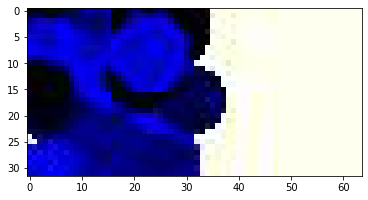

In [13]:
plt.imshow(train_images[0])

### After conversion

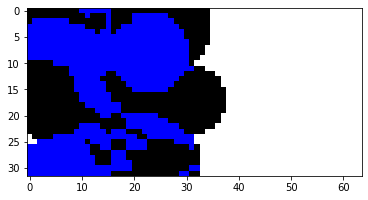

In [18]:
image, histogram = convert_nearest_std_colors(train_images[0])
plt.imshow(image)

# Step 3: Preparing the output

In [8]:
test_imgs = pd.read_csv('../input/synimg/synimg/test/data_nostyle.csv', nrows=10)
test_imgs.head(1)

,id,file,filepath
0,9000000,test-A-9000000.jpg,synimg/test/A/test-A-9000000.jpg


In [9]:
test_data, test_images = read_data_from_file('synimg/test/data_nostyle.csv', nrows=10)


Making prediction

In [10]:
pred_labels = dummy_model(test_images)
test_data['label_id'] = pred_labels
test_data['style_name'] = test_data['label_id'].map(labelId_to_label)

# Some vaidaition of the output
from collections import Counter
print(Counter(test_data['style_name']))

Counter({'Geneva': 2, 'Singapore': 2, 'Zurich': 1, 'Sydney': 1, 'Luanda': 1, 'Beijing': 1, 'Brisbane': 1, 'Melbourne': 1})


### Prepare submission file

In [11]:
test_data[['id', 'style_name']].to_csv('../submit.csv', index=False)